<a href="https://colab.research.google.com/github/Sebastien01/images_classification/blob/master/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [3]:
train_path = 'C:\\Users\Aysel Gojayeva\Desktop\CS-HW-week11\Python\Data\seg_train'
test_path = 'C:\\Users\Aysel Gojayeva\Desktop\CS-HW-week11\Python\Data\seg_test'
pred_path = 'C:\\Users\Aysel Gojayeva\Desktop\CS-HW-week11\Python\Data\seg_pred'

IMG_SIZE = (160,160)
BATCH_SIZE = 32

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [6]:
train_dataset = image_dataset_from_directory(train_path,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             label_mode='categorical')

Found 11774 files belonging to 6 classes.


In [7]:
validation_dataset = image_dataset_from_directory(test_path,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  label_mode='categorical')

Found 2951 files belonging to 6 classes.


In [8]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [9]:
pred_dataset = image_dataset_from_directory(pred_path,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE,label_mode='categorical')

Found 7307 files belonging to 1 classes.


In [10]:
class_names = train_dataset.class_names

In [11]:
def plot_class_distribution(dataset,ds_name):
  class_array = np.concatenate(list(dataset.map(lambda image,label: label).as_numpy_iterator()),axis=0)
  class_count = [class_array[:,i].sum() for i in range(class_array.shape[1])]
  sns.barplot(y=class_count,x=class_names)
  plt.title(f'{ds_name} distribution')

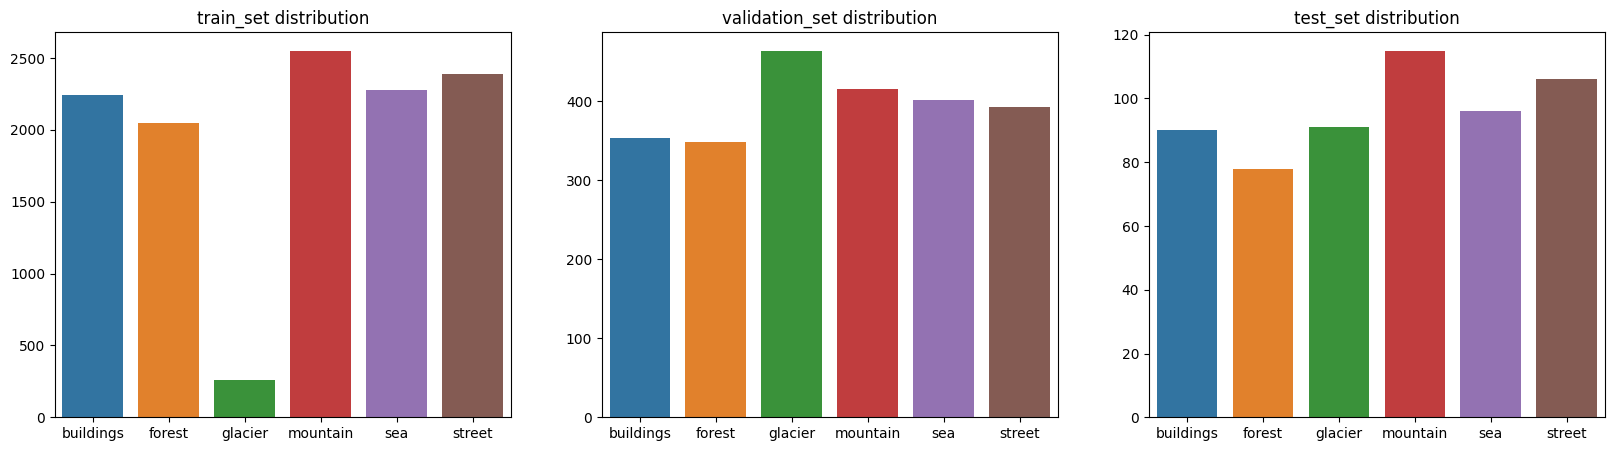

In [12]:
plt.figure(figsize=(20,5))
ax = plt.subplot(1,3,1)
plot_class_distribution(train_dataset,'train_set')
ax = plt.subplot(1,3,2)
plot_class_distribution(validation_dataset,'validation_set')
ax = plt.subplot(1,3,3)
plot_class_distribution(test_dataset,'test_set')

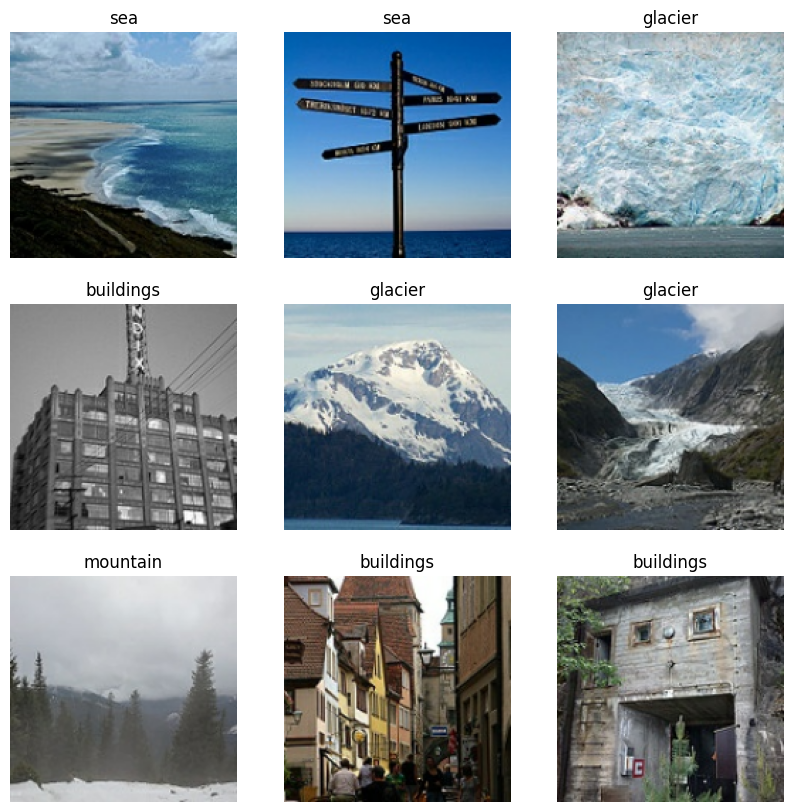

In [13]:
images,labels = next(iter(validation_dataset))
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[i].numpy().astype("uint8"))
  plt.title(class_names[labels[i].numpy().argmax()])
  plt.axis("off")

After a quick analysis of the datasets, we noticed that :
1. the `sea` class is under-represented 
2. Our datasets appear to be polluted by random mislabelled images 

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
pred_dataset = pred_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
preprocess_input = tf.keras.applications.xception.preprocess_input

In [16]:
# Create the base model from the pre-trained model xception
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.xception.Xception(input_shape=IMG_SHAPE,
                                                      include_top=False,
                                                      weights='imagenet')

83683744/83683744 [==============================] - 11s 0us/step


In [17]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


In [18]:
base_model.trainable = False

In [19]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 79, 79, 32)           864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 79, 79, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 79, 79, 32)           0         ['block1_conv1_bn[0][0]

                                                                                                  
 block4_sepconv2_act (Activ  (None, 20, 20, 728)          0         ['block4_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block4_sepconv2 (Separable  (None, 20, 20, 728)          536536    ['block4_sepconv2_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block4_sepconv2_bn (BatchN  (None, 20, 20, 728)          2912      ['block4_sepconv2[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 conv2d_2 

                                                                                                  
 block7_sepconv1 (Separable  (None, 10, 10, 728)          536536    ['block7_sepconv1_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block7_sepconv1_bn (BatchN  (None, 10, 10, 728)          2912      ['block7_sepconv1[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block7_sepconv2_act (Activ  (None, 10, 10, 728)          0         ['block7_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block7_se

 ormalization)                                                                                    
                                                                                                  
 add_7 (Add)                 (None, 10, 10, 728)          0         ['block9_sepconv3_bn[0][0]',  
                                                                     'add_6[0][0]']               
                                                                                                  
 block10_sepconv1_act (Acti  (None, 10, 10, 728)          0         ['add_7[0][0]']               
 vation)                                                                                          
                                                                                                  
 block10_sepconv1 (Separabl  (None, 10, 10, 728)          536536    ['block10_sepconv1_act[0][0]']
 eConv2D)                                                                                         
          

 block12_sepconv3_act (Acti  (None, 10, 10, 728)          0         ['block12_sepconv2_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 block12_sepconv3 (Separabl  (None, 10, 10, 728)          536536    ['block12_sepconv3_act[0][0]']
 eConv2D)                                                                                         
                                                                                                  
 block12_sepconv3_bn (Batch  (None, 10, 10, 728)          2912      ['block12_sepconv3[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 add_10 (Add)                (None, 10, 10, 728)          0         ['block12_sepconv3_bn[0][0]', 
          

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [21]:
prediction_layer = tf.keras.layers.Dense(6,activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 6)


In [22]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [23]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                             

In [25]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(test_dataset)

18/18 [==============================] - 14s 666ms/step - loss: 1.9332 - categorical_accuracy: 0.1024


In [26]:
print('Baseline loss:', loss0)
print('Baseline accuracy:', accuracy0)

Baseline loss: 1.9332093000411987
Baseline accuracy: 0.1024305522441864


In [27]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
368/368 [==============================] - 286s 771ms/step - loss: 0.9553 - categorical_accuracy: 0.7090 - val_loss: 1.0047 - val_categorical_accuracy: 0.7453
Epoch 2/10
368/368 [==============================] - 275s 749ms/step - loss: 0.4542 - categorical_accuracy: 0.8838 - val_loss: 0.7642 - val_categorical_accuracy: 0.7566
Epoch 3/10
368/368 [==============================] - 283s 770ms/step - loss: 0.3519 - categorical_accuracy: 0.9009 - val_loss: 0.6424 - val_categorical_accuracy: 0.7655
Epoch 4/10
368/368 [==============================] - 287s 780ms/step - loss: 0.3040 - categorical_accuracy: 0.9090 - val_loss: 0.5850 - val_categorical_accuracy: 0.7752
Epoch 5/10
368/368 [==============================] - 287s 780ms/step - loss: 0.2776 - categorical_accuracy: 0.9126 - val_loss: 0.5415 - val_categorical_accuracy: 0.7861
Epoch 6/10
368/368 [==============================] - 284s 773ms/step - loss: 0.2588 - categorical_accuracy: 0.9173 - val_loss: 0.5151 - val_categoric

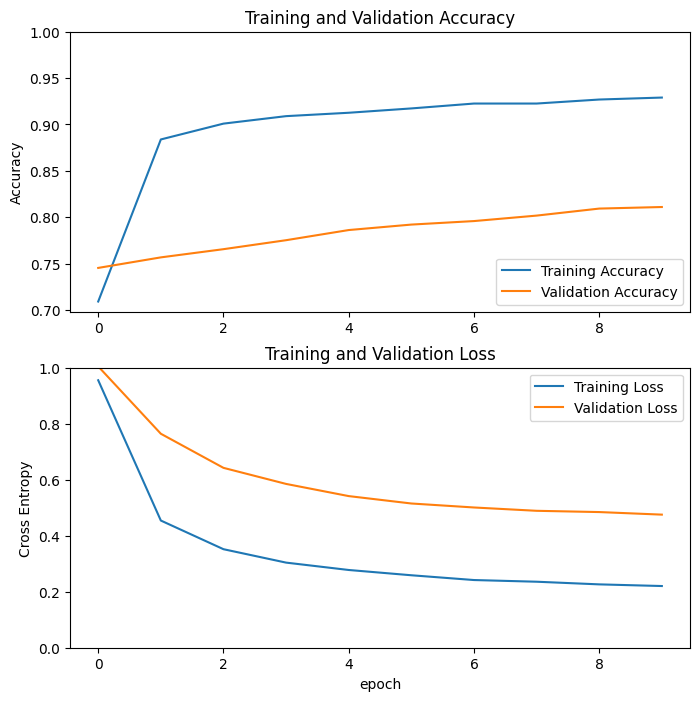

In [28]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [29]:
base_model.trainable = True

In [30]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  132


In [31]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [32]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=5, restore_best_weights=True,monitor='val_categorical_accuracy')

In [33]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=[es])

Epoch 10/20
368/368 [==============================] - 544s 1s/step - loss: 0.1874 - categorical_accuracy: 0.9367 - val_loss: 0.4195 - val_categorical_accuracy: 0.8408
Epoch 11/20
368/368 [==============================] - 527s 1s/step - loss: 0.1564 - categorical_accuracy: 0.9481 - val_loss: 0.3978 - val_categorical_accuracy: 0.8501
Epoch 12/20
368/368 [==============================] - 535s 1s/step - loss: 0.1337 - categorical_accuracy: 0.9548 - val_loss: 0.3908 - val_categorical_accuracy: 0.8552
Epoch 13/20
368/368 [==============================] - 552s 1s/step - loss: 0.1142 - categorical_accuracy: 0.9612 - val_loss: 0.3902 - val_categorical_accuracy: 0.8598
Epoch 14/20
368/368 [==============================] - 558s 2s/step - loss: 0.1022 - categorical_accuracy: 0.9661 - val_loss: 0.3794 - val_categorical_accuracy: 0.8619
Epoch 15/20
368/368 [==============================] - 551s 1s/step - loss: 0.0876 - categorical_accuracy: 0.9702 - val_loss: 0.3745 - val_categorical_accuracy:

In [34]:
acc += history_fine.history['categorical_accuracy']
val_acc += history_fine.history['val_categorical_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

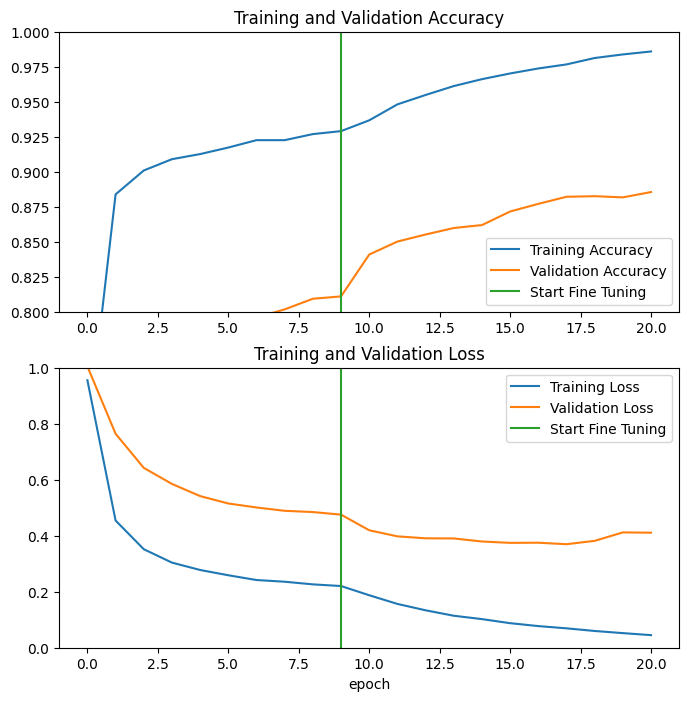

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [36]:
loss, accuracy = model.evaluate(test_dataset)

18/18 [==============================] - 12s 663ms/step - loss: 0.4201 - categorical_accuracy: 0.8976


TypeError: Invalid shape (32, 160, 160, 3) for image data

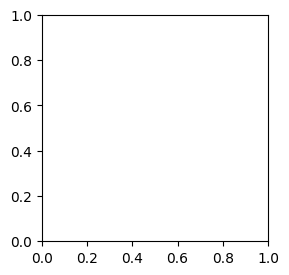

In [37]:
plt.figure(figsize=(10, 10))
for images in pred_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    #plt.title(class_names[labels[i].numpy().argmax()])
    #plt.axis("off")

In [38]:
preprocess_input = tf.keras.applications.xception.preprocess_input
# Create the base model from the pre-trained model xception
IMG_SHAPE = IMG_SIZE + (3,)

In [39]:
resnet_base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(input_shape=IMG_SHAPE,
                                                      include_top=False,
                                                      weights='imagenet')

219055592/219055592 [==============================] - 38s 0us/step


In [40]:
resnet_base_model.trainable = False

In [41]:
resnet_base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 79, 79, 32)           864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_4 (Bat  (None, 79, 79, 32)           96        ['conv2d_4[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation (Activation)     (None, 79, 79, 32)           0         ['batch_norm

                                                                                                  
 conv2d_15 (Conv2D)          (None, 17, 17, 64)           12288     ['average_pooling2d[0][0]']   
                                                                                                  
 batch_normalization_9 (Bat  (None, 17, 17, 96)           288       ['conv2d_9[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_11 (Ba  (None, 17, 17, 64)           192       ['conv2d_11[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_14 (Ba  (None, 17, 17, 96)           288       ['conv2d_14[0][0]']           
 tchNormal

                                                                                                  
 block35_1_conv (Conv2D)     (None, 17, 17, 320)          41280     ['block35_1_mixed[0][0]']     
                                                                                                  
 custom_scale_layer (Custom  (None, 17, 17, 320)          0         ['mixed_5b[0][0]',            
 ScaleLayer)                                                         'block35_1_conv[0][0]']      
                                                                                                  
 block35_1_ac (Activation)   (None, 17, 17, 320)          0         ['custom_scale_layer[0][0]']  
                                                                                                  
 conv2d_25 (Conv2D)          (None, 17, 17, 32)           10240     ['block35_1_ac[0][0]']        
                                                                                                  
 batch_nor

 tchNormalization)                                                                                
                                                                                                  
 activation_25 (Activation)  (None, 17, 17, 32)           0         ['batch_normalization_29[0][0]
                                                                    ']                            
                                                                                                  
 activation_28 (Activation)  (None, 17, 17, 48)           0         ['batch_normalization_32[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_28 (Conv2D)          (None, 17, 17, 32)           10240     ['block35_2_ac[0][0]']        
                                                                                                  
 conv2d_30

                                                                    ']                            
                                                                                                  
 activation_32 (Activation)  (None, 17, 17, 32)           0         ['batch_normalization_36[0][0]
                                                                    ']                            
                                                                                                  
 activation_35 (Activation)  (None, 17, 17, 64)           0         ['batch_normalization_39[0][0]
                                                                    ']                            
                                                                                                  
 block35_4_mixed (Concatena  (None, 17, 17, 128)          0         ['activation_30[0][0]',       
 te)                                                                 'activation_32[0][0]',       
          

 activation_45 (Activation)  (None, 17, 17, 32)           0         ['batch_normalization_49[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_47 (Conv2D)          (None, 17, 17, 32)           10240     ['block35_5_ac[0][0]']        
                                                                                                  
 conv2d_50 (Conv2D)          (None, 17, 17, 48)           13824     ['activation_45[0][0]']       
                                                                                                  
 batch_normalization_47 (Ba  (None, 17, 17, 32)           96        ['conv2d_47[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_nor

                                                                                                  
 batch_normalization_52 (Ba  (None, 17, 17, 32)           96        ['conv2d_52[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_54 (Ba  (None, 17, 17, 32)           96        ['conv2d_54[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_57 (Ba  (None, 17, 17, 64)           192       ['conv2d_57[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activatio

                                                                                                  
 custom_scale_layer_7 (Cust  (None, 17, 17, 320)          0         ['block35_7_ac[0][0]',        
 omScaleLayer)                                                       'block35_8_conv[0][0]']      
                                                                                                  
 block35_8_ac (Activation)   (None, 17, 17, 320)          0         ['custom_scale_layer_7[0][0]']
                                                                                                  
 conv2d_67 (Conv2D)          (None, 17, 17, 32)           10240     ['block35_8_ac[0][0]']        
                                                                                                  
 batch_normalization_67 (Ba  (None, 17, 17, 32)           96        ['conv2d_67[0][0]']           
 tchNormalization)                                                                                
          

 activation_67 (Activation)  (None, 17, 17, 32)           0         ['batch_normalization_71[0][0]
                                                                    ']                            
                                                                                                  
 activation_70 (Activation)  (None, 17, 17, 48)           0         ['batch_normalization_74[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_70 (Conv2D)          (None, 17, 17, 32)           10240     ['block35_9_ac[0][0]']        
                                                                                                  
 conv2d_72 (Conv2D)          (None, 17, 17, 32)           9216      ['activation_67[0][0]']       
                                                                                                  
 conv2d_75

 tchNormalization)                                                                                
                                                                                                  
 activation_77 (Activation)  (None, 8, 8, 128)            0         ['batch_normalization_81[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_82 (Conv2D)          (None, 8, 8, 160)            143360    ['activation_77[0][0]']       
                                                                                                  
 batch_normalization_82 (Ba  (None, 8, 8, 160)            480       ['conv2d_82[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activatio

 conv2d_89 (Conv2D)          (None, 8, 8, 128)            139264    ['block17_2_ac[0][0]']        
                                                                                                  
 batch_normalization_89 (Ba  (None, 8, 8, 128)            384       ['conv2d_89[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_85 (Activation)  (None, 8, 8, 128)            0         ['batch_normalization_89[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_90 (Conv2D)          (None, 8, 8, 160)            143360    ['activation_85[0][0]']       
                                                                                                  
 batch_nor

 block17_4_ac (Activation)   (None, 8, 8, 1088)           0         ['custom_scale_layer_13[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_97 (Conv2D)          (None, 8, 8, 128)            139264    ['block17_4_ac[0][0]']        
                                                                                                  
 batch_normalization_97 (Ba  (None, 8, 8, 128)            384       ['conv2d_97[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_93 (Activation)  (None, 8, 8, 128)            0         ['batch_normalization_97[0][0]
                                                                    ']                            
          

 custom_scale_layer_15 (Cus  (None, 8, 8, 1088)           0         ['block17_5_ac[0][0]',        
 tomScaleLayer)                                                      'block17_6_conv[0][0]']      
                                                                                                  
 block17_6_ac (Activation)   (None, 8, 8, 1088)           0         ['custom_scale_layer_15[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_105 (Conv2D)         (None, 8, 8, 128)            139264    ['block17_6_ac[0][0]']        
                                                                                                  
 batch_normalization_105 (B  (None, 8, 8, 128)            384       ['conv2d_105[0][0]']          
 atchNormalization)                                                                               
          

                                                                                                  
 block17_8_conv (Conv2D)     (None, 8, 8, 1088)           418880    ['block17_8_mixed[0][0]']     
                                                                                                  
 custom_scale_layer_17 (Cus  (None, 8, 8, 1088)           0         ['block17_7_ac[0][0]',        
 tomScaleLayer)                                                      'block17_8_conv[0][0]']      
                                                                                                  
 block17_8_ac (Activation)   (None, 8, 8, 1088)           0         ['custom_scale_layer_17[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_113 (Conv2D)         (None, 8, 8, 128)            139264    ['block17_8_ac[0][0]']        
          

                                                                                                  
 block17_10_mixed (Concaten  (None, 8, 8, 384)            0         ['activation_112[0][0]',      
 ate)                                                                'activation_115[0][0]']      
                                                                                                  
 block17_10_conv (Conv2D)    (None, 8, 8, 1088)           418880    ['block17_10_mixed[0][0]']    
                                                                                                  
 custom_scale_layer_19 (Cus  (None, 8, 8, 1088)           0         ['block17_9_ac[0][0]',        
 tomScaleLayer)                                                      'block17_10_conv[0][0]']     
                                                                                                  
 block17_10_ac (Activation)  (None, 8, 8, 1088)           0         ['custom_scale_layer_19[0][0]'
          

                                                                                                  
 activation_123 (Activation  (None, 8, 8, 192)            0         ['batch_normalization_127[0][0
 )                                                                  ]']                           
                                                                                                  
 block17_12_mixed (Concaten  (None, 8, 8, 384)            0         ['activation_120[0][0]',      
 ate)                                                                'activation_123[0][0]']      
                                                                                                  
 block17_12_conv (Conv2D)    (None, 8, 8, 1088)           418880    ['block17_12_mixed[0][0]']    
                                                                                                  
 custom_scale_layer_21 (Cus  (None, 8, 8, 1088)           0         ['block17_11_ac[0][0]',       
 tomScaleL

                                                                                                  
 activation_128 (Activation  (None, 8, 8, 192)            0         ['batch_normalization_132[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_131 (Activation  (None, 8, 8, 192)            0         ['batch_normalization_135[0][0
 )                                                                  ]']                           
                                                                                                  
 block17_14_mixed (Concaten  (None, 8, 8, 384)            0         ['activation_128[0][0]',      
 ate)                                                                'activation_131[0][0]']      
                                                                                                  
 block17_1

                                                                                                  
 batch_normalization_143 (B  (None, 8, 8, 192)            576       ['conv2d_143[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_136 (Activation  (None, 8, 8, 192)            0         ['batch_normalization_140[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_139 (Activation  (None, 8, 8, 192)            0         ['batch_normalization_143[0][0
 )                                                                  ]']                           
                                                                                                  
 block17_1

                                                                                                  
 batch_normalization_148 (B  (None, 8, 8, 192)            576       ['conv2d_148[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_151 (B  (None, 8, 8, 192)            576       ['conv2d_151[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_144 (Activation  (None, 8, 8, 192)            0         ['batch_normalization_148[0][0
 )                                                                  ]']                           
                                                                                                  
 activatio

 conv2d_156 (Conv2D)         (None, 8, 8, 192)            208896    ['block17_19_ac[0][0]']       
                                                                                                  
 conv2d_159 (Conv2D)         (None, 8, 8, 192)            215040    ['activation_154[0][0]']      
                                                                                                  
 batch_normalization_156 (B  (None, 8, 8, 192)            576       ['conv2d_156[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_159 (B  (None, 8, 8, 192)            576       ['conv2d_159[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activatio

 max_pooling2d_3 (MaxPoolin  (None, 3, 3, 1088)           0         ['block17_20_ac[0][0]']       
 g2D)                                                                                             
                                                                                                  
 mixed_7a (Concatenate)      (None, 3, 3, 2080)           0         ['activation_157[0][0]',      
                                                                     'activation_159[0][0]',      
                                                                     'activation_162[0][0]',      
                                                                     'max_pooling2d_3[0][0]']     
                                                                                                  
 conv2d_168 (Conv2D)         (None, 3, 3, 192)            399360    ['mixed_7a[0][0]']            
                                                                                                  
 batch_nor

 block8_2_mixed (Concatenat  (None, 3, 3, 448)            0         ['activation_167[0][0]',      
 e)                                                                  'activation_170[0][0]']      
                                                                                                  
 block8_2_conv (Conv2D)      (None, 3, 3, 2080)           933920    ['block8_2_mixed[0][0]']      
                                                                                                  
 custom_scale_layer_31 (Cus  (None, 3, 3, 2080)           0         ['block8_1_ac[0][0]',         
 tomScaleLayer)                                                      'block8_2_conv[0][0]']       
                                                                                                  
 block8_2_ac (Activation)    (None, 3, 3, 2080)           0         ['custom_scale_layer_31[0][0]'
                                                                    ]                             
          

 activation_178 (Activation  (None, 3, 3, 256)            0         ['batch_normalization_182[0][0
 )                                                                  ]']                           
                                                                                                  
 block8_4_mixed (Concatenat  (None, 3, 3, 448)            0         ['activation_175[0][0]',      
 e)                                                                  'activation_178[0][0]']      
                                                                                                  
 block8_4_conv (Conv2D)      (None, 3, 3, 2080)           933920    ['block8_4_mixed[0][0]']      
                                                                                                  
 custom_scale_layer_33 (Cus  (None, 3, 3, 2080)           0         ['block8_3_ac[0][0]',         
 tomScaleLayer)                                                      'block8_4_conv[0][0]']       
          

 activation_183 (Activation  (None, 3, 3, 192)            0         ['batch_normalization_187[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_186 (Activation  (None, 3, 3, 256)            0         ['batch_normalization_190[0][0
 )                                                                  ]']                           
                                                                                                  
 block8_6_mixed (Concatenat  (None, 3, 3, 448)            0         ['activation_183[0][0]',      
 e)                                                                  'activation_186[0][0]']      
                                                                                                  
 block8_6_conv (Conv2D)      (None, 3, 3, 2080)           933920    ['block8_6_mixed[0][0]']      
          

 batch_normalization_198 (B  (None, 3, 3, 256)            768       ['conv2d_198[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_191 (Activation  (None, 3, 3, 192)            0         ['batch_normalization_195[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_194 (Activation  (None, 3, 3, 256)            0         ['batch_normalization_198[0][0
 )                                                                  ]']                           
                                                                                                  
 block8_8_mixed (Concatenat  (None, 3, 3, 448)            0         ['activation_191[0][0]',      
 e)       

 batch_normalization_203 (B  (None, 3, 3, 192)            576       ['conv2d_203[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_206 (B  (None, 3, 3, 256)            768       ['conv2d_206[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_199 (Activation  (None, 3, 3, 192)            0         ['batch_normalization_203[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_202 (Activation  (None, 3, 3, 256)            0         ['batch_normalization_206[0][0
 )        

In [42]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = resnet_base_model(image_batch)
print(feature_batch.shape)

(32, 3, 3, 1536)


In [43]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
prediction_layer = tf.keras.layers.Dense(6,activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1536)
(32, 6)


In [44]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = resnet_base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
resnet_model = tf.keras.Model(inputs, outputs)

In [45]:
base_learning_rate = 0.0001
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
history = resnet_model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
415/415 [==============================] - 223s 505ms/step - loss: 0.7910 - categorical_accuracy: 0.7217 - val_loss: 0.4205 - val_categorical_accuracy: 0.8664
Epoch 2/10
415/415 [==============================] - 204s 489ms/step - loss: 0.3865 - categorical_accuracy: 0.8612 - val_loss: 0.3185 - val_categorical_accuracy: 0.8945
Epoch 3/10
415/415 [==============================] - 203s 487ms/step - loss: 0.3275 - categorical_accuracy: 0.8797 - val_loss: 0.2829 - val_categorical_accuracy: 0.9007
Epoch 4/10
415/415 [==============================] - 203s 487ms/step - loss: 0.2983 - categorical_accuracy: 0.8924 - val_loss: 0.2655 - val_categorical_accuracy: 0.9049
Epoch 5/10
415/415 [==============================] - 204s 491ms/step - loss: 0.2828 - categorical_accuracy: 0.8940 - val_loss: 0.2592 - val_categorical_accuracy: 0.9049
Epoch 6/10
415/415 [==============================] - 204s 490ms/step - loss: 0.2676 - categorical_accuracy: 0.9034 - val_loss: 0.2457 - val_categoric

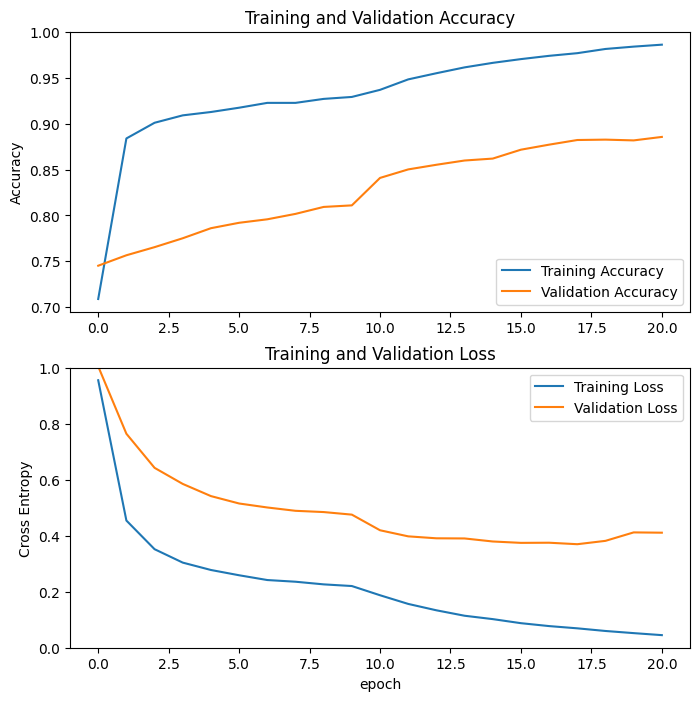

In [46]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [47]:
resnet_base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(resnet_base_model.layers))

Number of layers in the base model:  780


In [48]:
# Fine-tune from this layer onwards
fine_tune_at = 600

# Freeze all the layers before the `fine_tune_at` layer
for layer in resnet_base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [49]:
resnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [50]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=5, restore_best_weights=True,monitor='val_categorical_accuracy')

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = resnet_model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=[es])

Epoch 10/20
415/415 [==============================] - 290s 655ms/step - loss: 0.2155 - categorical_accuracy: 0.9213 - val_loss: 0.1916 - val_categorical_accuracy: 0.9305
Epoch 11/20
415/415 [==============================] - 268s 643ms/step - loss: 0.1578 - categorical_accuracy: 0.9418 - val_loss: 0.2002 - val_categorical_accuracy: 0.9305
Epoch 12/20
415/415 [==============================] - 267s 641ms/step - loss: 0.1158 - categorical_accuracy: 0.9604 - val_loss: 0.2136 - val_categorical_accuracy: 0.9305
Epoch 13/20
415/415 [==============================] - 267s 641ms/step - loss: 0.0798 - categorical_accuracy: 0.9725 - val_loss: 0.2343 - val_categorical_accuracy: 0.9322
Epoch 14/20
415/415 [==============================] - 267s 641ms/step - loss: 0.0519 - categorical_accuracy: 0.9805 - val_loss: 0.2643 - val_categorical_accuracy: 0.9359
Epoch 15/20
415/415 [==============================] - 267s 641ms/step - loss: 0.0319 - categorical_accuracy: 0.9890 - val_loss: 0.4547 - val_cat

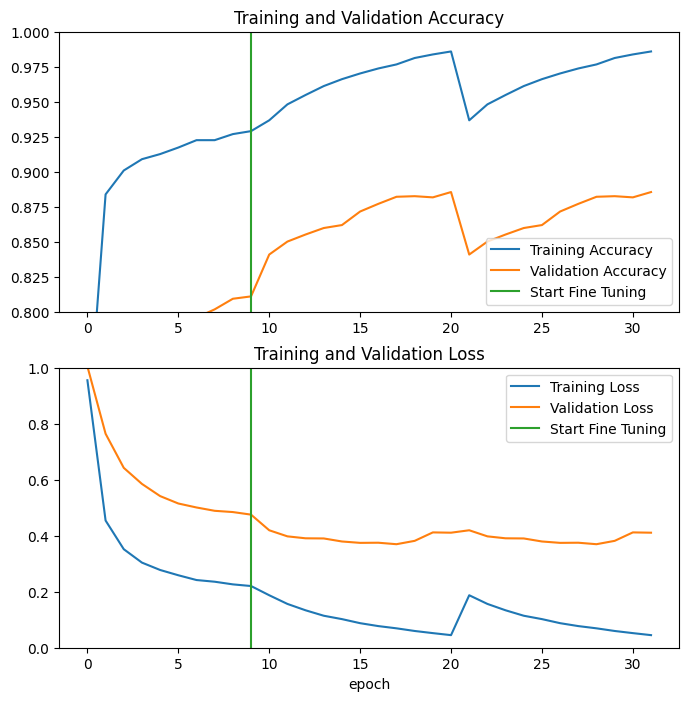

In [51]:
acc += history_fine.history['categorical_accuracy']
val_acc += history_fine.history['val_categorical_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [56]:
from PIL import Image

# Assuming you have TensorFlow and tf.data.Dataset
import tensorflow as tf

# Resize the test dataset to match the model's expected input size
resized_test_dataset = test_dataset.map(lambda x, y: (tf.image.resize(x, (224, 224)), y))

# Evaluate the model
loss, accuracy = resnet_model.evaluate(resized_test_dataset)


ValueError: in user code:

    File "C:\Users\Aysel Gojayeva\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1972, in test_function  *
        return step_function(self, iterator)
    File "C:\Users\Aysel Gojayeva\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1956, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Aysel Gojayeva\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1944, in run_step  **
        outputs = model.test_step(data)
    File "C:\Users\Aysel Gojayeva\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1850, in test_step
        y_pred = self(x, training=False)
    File "C:\Users\Aysel Gojayeva\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Aysel Gojayeva\anaconda3\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'model_1' (type Functional).
    
    Input 0 of layer "inception_resnet_v2" is incompatible with the layer: expected shape=(None, 160, 160, 3), found shape=(None, 224, 224, 3)
    
    Call arguments received by layer 'model_1' (type Functional):
      • inputs=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
      • training=False
      • mask=None


In [52]:
loss, accuracy = resnet_model.evaluate(test_dataset)

ValueError: in user code:

    File "C:\Users\Aysel Gojayeva\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1972, in test_function  *
        return step_function(self, iterator)
    File "C:\Users\Aysel Gojayeva\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1956, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Aysel Gojayeva\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1944, in run_step  **
        outputs = model.test_step(data)
    File "C:\Users\Aysel Gojayeva\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1850, in test_step
        y_pred = self(x, training=False)
    File "C:\Users\Aysel Gojayeva\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Aysel Gojayeva\anaconda3\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 160, 160, 3)


In [53]:
from tensorflow.keras.models import save_model

In [54]:
save_model(model,'/content/drive/MyDrive/image_scene/InceptionResNet')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/image_scene/InceptionResNet\assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/image_scene/InceptionResNet\assets
